<a href="https://colab.research.google.com/github/YI-CHENG-SHIH645/ML-in-Business_practice/blob/main/ch5_svm/SVM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [233]:
#@title Imports
!wget "https://github.com/YI-CHENG-SHIH645/ML-in-Business_practice/raw/main/utils.py"
!pip install -i https://pypi.gurobi.com gurobipy

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import gurobipy
from sklearn.datasets import make_circles
from sklearn.svm import SVC

--2021-04-16 15:26:18--  https://github.com/YI-CHENG-SHIH645/ML-in-Business_practice/raw/main/utils.py
Resolving github.com (github.com)... 140.82.113.3
Connecting to github.com (github.com)|140.82.113.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/YI-CHENG-SHIH645/ML-in-Business_practice/main/utils.py [following]
--2021-04-16 15:26:18--  https://raw.githubusercontent.com/YI-CHENG-SHIH645/ML-in-Business_practice/main/utils.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7290 (7.1K) [text/plain]
Saving to: ‘utils.py.2’

utils.py.2          100%[===================>]   7.12K  --.-KB/s    in 0s      

2021-04-16 15:26:19 (45.5 MB/s) - ‘utils.py.2’ saved [7290/7290]

Looking in indexes: https

In [234]:
income = [30, 55, 63, 35, 28, 140, 100, 95, 64, 63]
credit_score = [40, 30, 30, 80, 100, 30, 30, 90, 120, 150]
label = [0, 0, 0, 0, 0, 1, 1, 1, 1, 1]

data = pd.DataFrame(np.array([income, credit_score, label]).T,
                    columns=['income', 'credit_score', 'label'])
data

,income,credit_score,label
0,30,40,0
1,55,30,0
2,63,30,0
3,35,80,0
4,28,100,0
5,140,30,1
6,100,30,1
7,95,90,1
8,64,120,1
9,63,150,1


In [235]:
#@title hard margin classification

def get_best_line(w1, w2, b):
    x1 = np.linspace(0, 140, 10000)
    x2 = (b - w1 * x1) / w2
    cond = x2 >= 0
    x2 = x2[cond]
    x1 = x1[cond]
    return x1, x2

def plt_res(*args):
    fig, ax = plt.subplots(figsize=(6, 4))
    sns.scatterplot(x='income',
                    y='credit_score',
                    data=data,
                    style='label',
                    markers={0: 'o', 1: 's'},
                    s=65,
                    ax=ax)

    ax.set_ylim(bottom=0, top=300)
    ax.set_xlim(left=0)

    if len(args):
        w1, w2, b = args
        ax.plot(*get_best_line(w1, w2, b))
        ax.plot(*get_best_line(w1, w2, b+1), '--')
        ax.plot(*get_best_line(w1, w2, b-1), '--')
    plt.show()

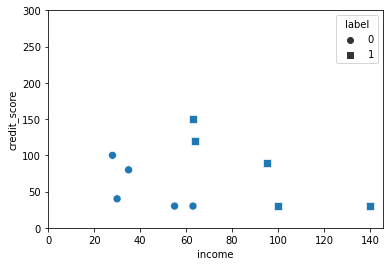

In [236]:
plt_res()

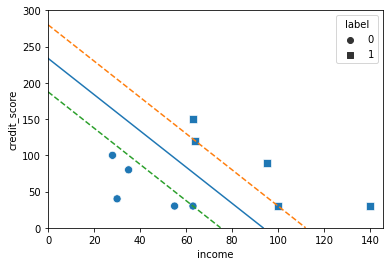

In [237]:
w1, w2, b = 0.05405, 0.02162, 5.054
plt_res(w1, w2, b)

middle line: $w_1x_1 + w_2x_2 = b$ <br>
upper line: $w_1x_1 + w_2x_2 = b_U$ <br>
lower line: $w_1x_1 + w_2x_2 = b_L$ <br>
可以進一步設 $b_U = b+1, b_L = b-1$, 不會影響找到的線 <br>
設 upper & lower 間的寬度為 P <br>
可以推得 $P = \frac{b_U - b_L}{\sqrt{w_1^2 + w_2^2}} = \frac{2}{\sqrt{w_1^2 + w_2^2}}$ <br>
要最大化 P
>最小化 $ w_1^2 + w_2^2 $ <br>

under constraints: 
> $ w_1x_{k1} + w_2x_{k2} >= b+1 $ if $ x_k \in class_1$  <br>
$ w_1x_{k1} + w_2x_{k2} <= b-1 $ <br><br>

how to solve w1, w2, b?
> Quadratic Programming

In [238]:
def model_setup(data):
    model = gurobipy.Model()
    model.Params.OutputFlag = 0
    num_of_params = data.shape[1]
    params_name = ["x{}".format(i) for i in range(1, num_of_params)] + ['b']
    params = model.addVars(params_name)

    return model, params

0.054 0.022 5.054


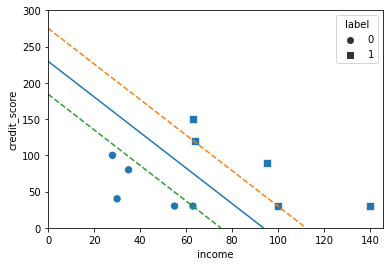

In [239]:
model, params = model_setup(data)
params_name = params.keys()

coefs_1 = [dict(zip(params_name[:-1], coef[:-1])) for coef in data.values if coef[-1]]
model.addConstrs(params.prod(coefs_1[i]) >= params['b']+1 for i in range(len(coefs_1)))
coefs_0 = [dict(zip(params_name[:-1], coef[:-1])) for coef in data.values if not coef[-1]]
model.addConstrs(params.prod(coefs_0[i]) <= params['b']-1 for i in range(len(coefs_0)))
model.setObjective(params['x1']**2 + params['x2']**2, gurobipy.GRB.MINIMIZE)
model.optimize()

w1, w2, b = (round(v.x, 3) for v in model.getVars())
print(w1, w2, b)

plt_res(w1, w2, b)

In [257]:
data.loc[2-1, 'credit_score'] = 140
data.loc[8-1, 'income'] = 60
data

,income,credit_score,label
0,30,40,0
1,55,140,0
2,63,30,0
3,35,80,0
4,28,100,0
5,140,30,1
6,100,30,1
7,60,90,1
8,64,120,1
9,63,150,1


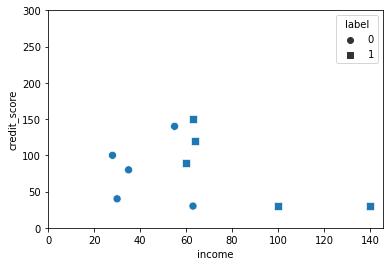

In [258]:
plt_res()

In [254]:
((data.iloc[:, :-1] @ np.array([1, 2])) > 200).astype(int)

0    0
1    0
2    0
3    0
4    1
5    0
6    0
7    1
8    1
9    1
dtype: int64

In [259]:
def soft_margin(C, data):
    model, params = model_setup(data)
    params_name = params.keys()

    coefs_1 = [dict(zip(params_name[:-1], coef[:-1])) for coef in data.values if coef[-1]]
    coefs_0 = [dict(zip(params_name[:-1], coef[:-1])) for coef in data.values if not coef[-1]]

    cls_error = model.addVars(range(len(data)))

    model.addConstrs(cls_error[i] >= (params['b']+1 - params.prod(coefs_1[i])) for i in range(len(coefs_1)))
    model.addConstrs(cls_error[i+len(coefs_1)] >= (params.prod(coefs_0[i]) - (params['b']-1)) for i in range(len(coefs_0)))
    c_part = C * gurobipy.quicksum(cls_error[i] for i in range(len(cls_error)))
    sq_sum = gurobipy.quicksum(params[x]**2 for x in params_name[:-1])
    model.setObjective(c_part + sq_sum, gurobipy.GRB.MINIMIZE)
    model.optimize()

    wb = [v.x for v in params.values()]
    w, b = wb[:-1], wb[-1]
    predicted_b = data.iloc[:, :-1] @ np.array(w)
    mis_cls = ((predicted_b - b > 0).astype(int) != data.iloc[:, -1]).sum() / len(data)
    path_width = 2 / np.sqrt(sum(wn**2 for wn in w))
    violations = sum([(b+1)-pb if label else pb-(b-1) for pb, label in zip(predicted_b, data.iloc[:, -1]) if b-1 < pb < b+1])
    
    info = [wn for wn in w]
    info.extend([b, mis_cls, path_width, violations, model.ObjVal])

    return tuple(info)

In [260]:
C = [.01, .001, .0005, .0003, .0002]
cols_name = ['C', 'w1', 'w2', 'b', 'mis_cls', 'path_width', 'violations']
results = np.concatenate((np.array(C).reshape(-1, 1), np.array([soft_margin(c, data)[:-1] for c in C])), axis=1)
results = pd.DataFrame(results, columns=cols_name)
results.round(4)

,C,w1,w2,b,mis_cls,path_width,violations
0,0.0100,0.0541,0.0216,5.0541,0.1,34.3536,2.8108
1,0.0010,0.0397,0.0122,3.3339,0.1,48.1785,3.3058
2,0.0005,0.0265,0.0100,2.5265,0.2,70.6114,4.7910
3,0.0003,0.0187,0.0057,1.7909,0.2,102.2153,5.7876
4,0.0002,0.0185,0.0033,1.6858,0.3,106.5540,5.9097


In [36]:
m = SVC(kernel='linear', C=0.01/2, tol=1e-6).fit(data.iloc[:, :-1], data.iloc[:, -1])
print(m.coef_.round(4), -m.intercept_.round(4))

[[0.0541 0.0216]] [5.0541]


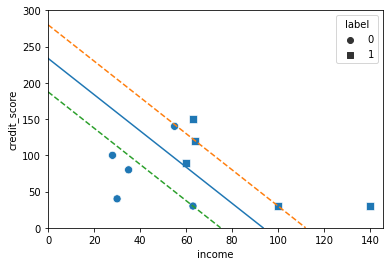

In [12]:
w1, w2, b = results[results['C'] == 0.01][['w1', 'w2', 'b']].values[0]

plt_res(w1, w2, b)

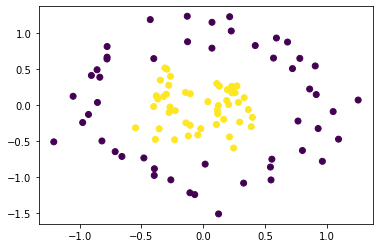

In [180]:
X, y = make_circles(100, factor=.3, noise=.15, random_state=0)
plt.scatter(X[:, 0], X[:, 1], c=y)
plt.show()

In [230]:
def rbf(center):
    return np.exp(-((X - center)**2).sum(1))
    
new_ax = [rbf(p) for p in X]
new_X = [pd.DataFrame(np.concatenate((X, new_ax[i].reshape(-1, 1)), axis=1)) for i in range(len(new_ax))]
scaled_new_X = [(df - df.mean()) / df.std() for df in new_X]
for df in scaled_new_X:
    df['y'] = y
all_possible_trans = np.array([soft_margin(C=0.01, data=data) for data in scaled_new_X])
best_model_arg = np.argmin(all_possible_trans[:, -1])
best_model_info = all_possible_trans[best_model_arg]

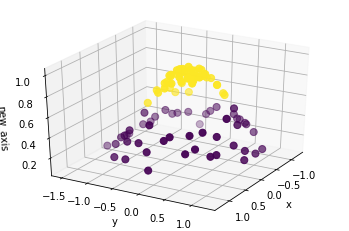

In [231]:
def plot_3D(elev=30, azim=30, X=X, y=y, wb=None):
    ax = plt.subplot(projection='3d')
    ax.scatter3D(X[:, 0], X[:, 1], X[:, 2], c=y, s=50)
    ax.view_init(elev=elev, azim=azim)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('new_axis')
    plt.show()

plot_3D(X=new_X[best_model_arg].values[:, :3], y=y)

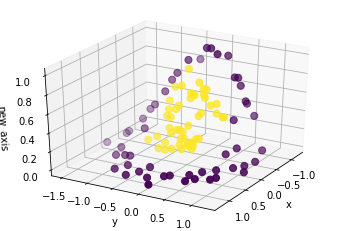

In [232]:
plot_3D(X=new_X[0].values[:, :3], y=y)